# plotting


In [5]:
# Enabling the `widget` backend.
# This requires jupyter-matplotlib a.k.a. ipympl.
# ipympl can be install via pip or conda.
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

In [6]:
%store -r log_text
from micropython_magic.memoryinfo import MemoryInfoList
mi_list = MemoryInfoList(show_free=False)
print(f"Loaded and parsed {len(mi_list.parse_log(log_text))} memory_info records from the log file")

Loaded and parsed 289 memory_info records from the log file


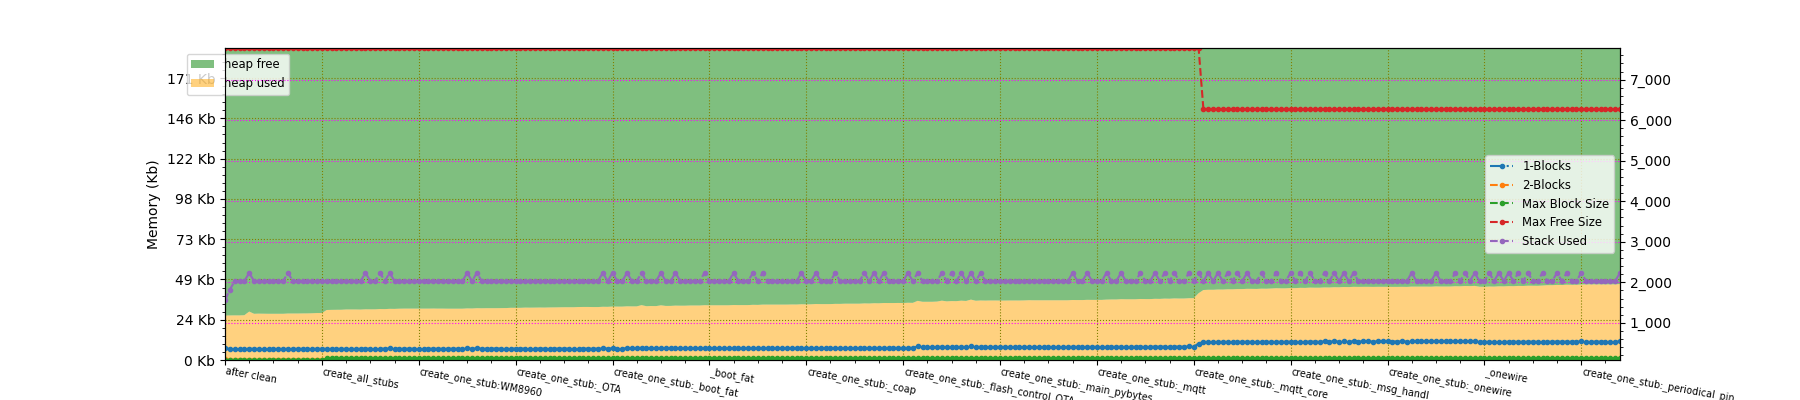

In [10]:
from typing import Dict, List
from micropython_magic.memoryinfo import MemoryInfoList
import matplotlib
import warnings
from matplotlib.lines import Line2D
from matplotlib.backend_bases import MouseEvent

KB_DIVIDER = 1024
LEGEND_L_BOX = (0.0, 0.0, 0.05, 1)
LEGEND_R_BOX = (0.7, 0.0, 0.3, 1)


def meminfo_plot(
    mi_list: MemoryInfoList,
    title: str = "Memory Info",
    # used: bool = True,
    free: bool = False,
    stack_total: bool = False,
    one_blocks: bool = False,
    two_blocks: bool = False,
    max_block_size: bool = False,
    max_free_size: bool = False,
    stack_used: bool = False,
    add_legend: bool = True,
    size=(12, 4),  # Figure dimension (width, height) in inches.
):  # sourcery skip: last-if-guard
    fig, ax1 = plt.subplots(figsize=size)  # , layout="constrained")
    fig.set_label(title)

    # prep the data
    x = np.arange(len(mi_list))
    # use the memory info list to get the data
    a_free = mi_list.np_array["free"]
    a_used = mi_list.np_array["used"]
    mi_list.np_array["stack"] = mi_list.np_array["stack"]
    ##################################################################################
    # configure both axes
    ##################################################################################
    ax1.yaxis.set_major_formatter(lambda x, pos: f"{x/KB_DIVIDER:_.0f} Kb")  # integers in thousands notation
    ax1.set_ylabel("Memory (Kb)")
    ax1.set_xlabel("snapshots / Time -->")
    ax1.set_xmargin(0)
    ax1.set_ymargin(0)
    ##################################################################################
    # Create twin Axes that shares the x-axis
    ax2 = ax1.twinx()
    ax2.yaxis.set_major_formatter("{x:_.0f}")
    ax2.set_ymargin(0)
    # Add grid for all axes with different styles
    ax1.grid(True, linestyle="dotted", color="olive")
    ax2.grid(True, axis="y", linestyle=":", color="fuchsia")
    ##################################################################################
    # Set x-axis ticks to the mi_list name
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # ignore the warning
        # 'UserWarning: FixedFormatter should only be used together with FixedLocator'
        ax1.set_xticklabels([i.name for i in mi_list])
    # Show 20 ticks at most
    ax1.locator_params(axis="x", nbins=20)
    # show minor ticks
    ax1.minorticks_on()
    ax2.minorticks_on()
    ##################################################################################
    # adjust display of the x-axis labels
    for label in ax1.get_xticklabels():
        label.set_horizontalalignment("left")
        label.set_rotation(-10)
        label.set_fontsize("x-small")
        label.set_fontweight("light")
        # move the labels a bit up
        label.set_y(label.get_position()[1] + 0.01)
    # make more room for the labels below  the figure
    fig.subplots_adjust(bottom=0.1)

    ##################################################################################
    # Add stackplot of free, used and stack memory if requested
    labels = ["heap used"]
    colors = ["orange"]
    data = [a_used]
    if free:
        labels.append("heap free")
        colors.append("green")
        data.append(a_free)
    if stack_total:
        labels.append("stack total")
        colors.append("purple")
        data.append(mi_list.np_array["stack"])

    s_plot = ax1.stackplot(x, data, labels=labels, colors=colors, alpha=0.5)

    my_lines: List[Line2D] = []
    # Add line charts to 2nd axis
    if one_blocks:
        my_lines += ax2.plot(x, mi_list.np_array["1-blocks"], label="1-Blocks", marker=".", linestyle="-.")
    if two_blocks:
        my_lines += ax2.plot(x, mi_list.np_array["2-blocks"], label="2-Blocks", marker=".", linestyle="--")
    if max_block_size:
        my_lines += ax2.plot(x, mi_list.np_array["max block"], label="Max Block Size", marker=".", linestyle="--")
    if max_free_size:
        my_lines += ax2.plot(x, mi_list.np_array["max free"], label="Max Free Size", marker=".", linestyle="--")
    if stack_used:
        my_lines += ax2.plot(x, mi_list.np_array["stack used"], label="Stack Used", marker=".", linestyle="--")

    if add_legend:
        # Add legend and show plot, best location left-ish top
        ax1.legend(loc="best", reverse=True, bbox_to_anchor=LEGEND_L_BOX, fontsize="small")
        #  bbox (x, y, width, height) - best location right-ish top
        ax2.legend(loc="best", bbox_to_anchor=LEGEND_R_BOX, fontsize="small")
    plt.tick_params(bottom="on")

    # create the annotations box, and hide it for now
    annot = ax2.annotate(
        "",
        xy=(0, 0),
        xytext=(-20, 20),
        textcoords="offset points",
        bbox=dict(boxstyle="round", fc="w"),
        arrowprops=dict(arrowstyle="->"),
    )
    annot.set_visible(False)

    def update_annot(line: Line2D, ind: Dict):
        """Update the annotation box with the data from the selected line."""
        x, y = line.get_data()
        # get the list index of the selected data point
        indx = ind["ind"][0]
        annot.xy = (x[indx], y[indx])
        ## get the text from the line object
        text = f"{line.get_label()} = {y[indx]:_.0f}\n@{mi_list[indx].name}\nMemory used: {mi_list[indx].used:_.0f} b, free {mi_list[indx].free:_.0f} b"
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)  # set the transparency of the box # type: ignore

    def hover(event: MouseEvent):
        """On mouse-hovewr over a line, display the corresponding data point value"""
        if event.inaxes in [ax1, ax2]:
            vis = annot.get_visible()
            cont = False
            for line in my_lines:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(line, ind)
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                    break
            if not cont:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    # connect the hover-function to the mouse
    fig.canvas.mpl_connect("motion_notify_event", hover)
    return fig


# clean up previous plot - save memory
plt.close()

fig1 = meminfo_plot(
    mi_list,
    free=True,
    # stack_total=True,
    one_blocks=True,
    two_blocks=True,
    max_block_size=True,
    max_free_size=True,
    stack_used=True,
    size=(18, 4),
)
plt.show(fig1)

You can also call `display` on `fig.canvas` to display the interactive plot anywhere in the notebooke


Hover Over :

- https://stackoverflow.com/questions/7908636/how-to-add-hovering-annotations-to-a-plot/47166787#47166787
- https://stackoverflow.com/questions/55891285/how-to-make-labels-appear-when-hovering-over-a-point-in-multiple-axis/55892690#55892690
-
